In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import ktrain
from ktrain import vision as vis

# Image Regression: Age Prediction

In this example, we will build a model that predicts the age of a person given the person's photo. 

## Download the Dataset

From [this blog post](https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed) by Abhik Jha, we see that there are several face datasets with age annotations from which to choose:
- [UTK Face Dataset](http://aicip.eecs.utk.edu/wiki/UTKFace)
- [IMDb-Wiki Face Dataset](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)
- [Appa Real Face Dataset](http://chalearnlap.cvc.uab.es/dataset/26/description/)

In this notebook, we use the UTK Face Dataset.   Download the data from [http://aicip.eecs.utk.edu/wiki/UTKFace](http://aicip.eecs.utk.edu/wiki/UTKFace) and extrct each of the three zip files to the same folder.


## STEP 1: Load and Preprocess the Dataset

The target **age** attribute in this dataset is encoded in the filename.  More specifically, filenames are of the form:
```
 [age]_[gender]_[race]_[date&time].jpg
```
where
- `[age]` is an integer from 0 to 116, indicating the age
- `[gender]` is either 0 (male) or 1 (female)
- `[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- `[date&time]` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

We are only interested in extracting the age for use as a numerical target.  Let us first construct a regular expression to extract the age from the filename.  Then, we can supply the pattern to `images_from_fname` to load and preprocess the dataset.  Supplying `is_regression=True` is important here, as it tells *ktrain* that the integer targets representing age should be treated as a numerical target, as oppposed to a class label.

In [2]:
# build a regular expression that extracts the age from file name
PATTERN = r'([^/]+)_\d+_\d+_\d+.jpg$'
import re
p = re.compile(PATTERN)
r = p.search('/hello/world/40_1_0_20170117134417715.jpg')
print("Extracted Age:%s" % (int(r.group(1))))

Extracted Age:40


Set `DATADIR` to the folder where you extracted all the images.

In [3]:
DATADIR='data/age_estimation/images'
data_aug = vis.get_data_aug(horizontal_flip=True)
(train_data, val_data, preproc) = vis.images_from_fname(DATADIR, pattern = PATTERN, data_aug = data_aug, 
                                                        is_regression=True, random_state=42)

/home/amaiya/projects/ghub/ktrain/ktrain/vision/data.py:744: UserWarning: Could not extract target for data/age_estimation/images/53__0_20170116184028385.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/home/amaiya/projects/ghub/ktrain/ktrain/vision/data.py:744: UserWarning: Could not extract target for data/age_estimation/images/39_1_20170116174525125.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/home/amaiya/projects/ghub/ktrain/ktrain/vision/data.py:744: UserWarning: Could not extract target for data/age_estimation/images/24_0_1_20170116220224657 .jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/home/amaiya/projects/ghub/ktrain/ktrain/vision/data.py:744: UserWarning: Could not extract target for data/age_estimation/images/61_3_20170109150557335.jpg -  skipping this file
  warnings.warn('Could not extract

Found 24107 images belonging to 1 classes.
Found 21669 validated image filenames.
Found 2432 validated image filenames.


From the warnings above, we see that a few filenames in the dataset are constructed incorrectly. For instance, the first filename incorrectly has two consecutive underscore characters after the age attribute. Although the age attribute appears to be intact despite the errors and we could modify the regular expression to process these files, we will ignore them in this demonstration.

## STEP 2: Create a  Model and Wrap in `Learner`

We use the `image_regression_model` function to create a `ResNet50` model.  By default, the model freezes all layers except the final randomly-initialized dense layer.

In [4]:
vis.print_image_regression_models()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized)
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized)
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized)
wrn22: 22-layer Wide Residual Network (randomly initialized)
default_cnn: a default LeNet-like Convolutional Neural Network


In [5]:
model = vis.image_regression_model('pretrained_resnet50', train_data, val_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
pretrained_resnet50 model created.


In [6]:
# wrap model and data in Learner object
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

## STEP 3: Estimate Learning Rate

We will select a learning rate associated with falling loss from the plot displayed.

In [7]:
learner.lr_find(max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Train for 338 steps
Epoch 1/2
338/338 [==============================] - 70s 207ms/step - loss: 861.5830 - mae: 22.9879
Epoch 2/2
109/338 [========>.....................] - ETA: 49s - loss: 649.4039 - mae: 16.9063

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


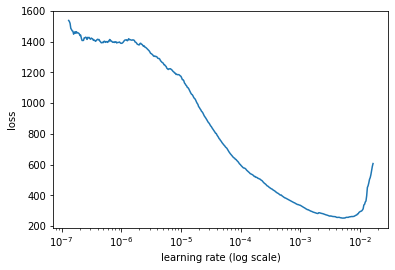

In [8]:
learner.lr_plot()

From the plot above, we choose a learning rate of `1e-4`.

## STEP 4: Train Model

We will begin by training the model for 3 epochs using a [1cycle](https://arxiv.org/abs/1803.09820) learning rate policy.

In [9]:
learner.fit_onecycle(1e-4, 3)



begin training using onecycle policy with max lr of 0.0001...
Train for 339 steps, validate for 76 steps
Epoch 1/3
339/339 [==============================] - 92s 272ms/step - loss: 439.4095 - mae: 15.9018 - val_loss: 232.3163 - val_mae: 11.5531
Epoch 2/3
339/339 [==============================] - 90s 267ms/step - loss: 224.5607 - mae: 11.4513 - val_loss: 205.7995 - val_mae: 11.0465
Epoch 3/3
339/339 [==============================] - 91s 270ms/step - loss: 195.5936 - mae: 10.7478 - val_loss: 204.4100 - val_mae: 11.0015


In [10]:
learner.freeze(15) # unfreeze all but the first 15 layers

In [11]:
learner.fit_onecycle(1e-4, 2)



begin training using onecycle policy with max lr of 0.0001...
Train for 339 steps, validate for 76 steps
Epoch 1/2
339/339 [==============================] - 116s 343ms/step - loss: 128.5147 - mae: 8.4811 - val_loss: 189.3961 - val_mae: 9.7832
Epoch 2/2
339/339 [==============================] - 111s 327ms/step - loss: 88.4419 - mae: 6.9415 - val_loss: 90.1048 - val_mae: 6.5764


After only 5 epochs, our validation MAE is 6.57.  That is, on average, our age predictions are off about 6 1/2 years.  Since it does not appear that we are overfitting yet, we could try training further for further improvement, but we will stop here for now.

## Make Predictions

Let's make predictions on individual photos. We could either randomly select from the entire image directory or select just from the validation images.

In [12]:
# get a Predictor instance that wraps model and Preprocessor object
predictor = ktrain.get_predictor(learner.model, preproc)

In [13]:
# get some random file names of images
!!ls {DATADIR} | sort -R |head -10

['20_1_3_20170119153148521.jpg',
 '80_0_0_20170117172944233.jpg',
 '14_1_0_20170104011733528.jpg',
 '36_1_0_20170117183244102.jpg',
 '34_0_0_20170117182731575.jpg',
 '25_1_3_20170104231534609.jpg',
 '48_0_4_20170117204131728.jpg',
 '25_0_1_20170113151453752.jpg',
 '15_0_3_20170105183235993.jpg',
 '32_1_2_20170116164214489.jpg']

In [41]:
# how to get validation filepaths
val_data.filenames[10:20]

['8_1_4_20170109201844552.jpg',
 '75_0_3_20170105180253006.jpg',
 '22_1_4_20170103223330567.jpg',
 '28_0_4_20170117021421106.jpg',
 '31_1_1_20170116023825964.jpg',
 '26_1_0_20170116231512359.jpg',
 '23_1_4_20170117194303197.jpg',
 '14_0_4_20170103200837103.jpg',
 '60_0_3_20170119205726487.jpg',
 '28_1_2_20170116190131133.jpg']

In [42]:
def show_prediction(fname):
    fname = DATADIR+'/'+fname
    predicted = round(predictor.predict_filename(fname)[0])
    actual = int(p.search(fname).group(1))
    vis.show_image(fname)
    print('predicted:%s | actual: %s' % (predicted, actual))

predicted:22.0 | actual: 25


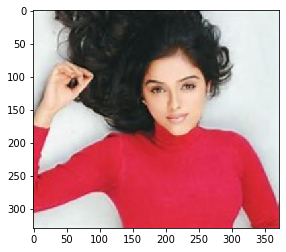

In [37]:
show_prediction('25_1_3_20170104231305129.jpg')

predicted:8.0 | actual: 10


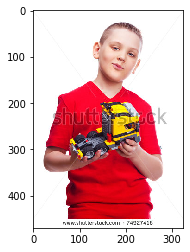

In [44]:
show_prediction('10_0_0_20170110225013755.jpg')

predicted:65.0 | actual: 71


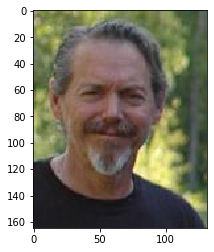

In [45]:
show_prediction('71_0_0_20170111204446510.jpg')

In [48]:
predictor.save('/tmp/age_predictor')

In [49]:
reloaded_predictor = ktrain.load_predictor('/tmp/age_predictor')

In [52]:
reloaded_predictor.predict_filename(DATADIR+'/60_0_3_20170119205726487.jpg')

array([54.259617], dtype=float32)

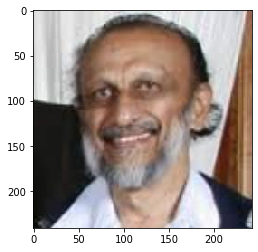

In [53]:
vis.show_image(DATADIR+'/60_0_3_20170119205726487.jpg')